### 데이터 세트: 콘크리트 강도 예측

#### Features
- Cement: 시멘트 함유량
- Blast Furnace Slag: 용광로 내에서의 광재(광석 제련 후 남는 재)의 양
- Fly Ash: 먼지 발생량
- Water: 콘크리트를 만드는데 들어가는 물의 양
- Superplasticizer: 시멘트가 마른 뒤의 강성
- Coarse Aggregate: 시멘트 입자의 거친 정도
- Fine Aggregate: 시멘트의 고운 정도
- Age: 재보강이 필요해질 때까지 걸리는 시간

#### Target
- Strength: 콘크리트의 강도 (단위 /kN)

In [1]:
import pandas as pd
import numpy as np

# 데이터 세트 가져오기
c_df = pd.read_csv('../../datasets/concrete_data.csv')

c_df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [2]:
# 데이터 세트 정보 확인
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


### 이후 진행 순서
1. 우선 원본 데이터 세트 그대로 선형 회귀 모델에 fit
2. 만족스럽지 않은 결과가 나왔을 때는 전처리 다시 해보기
3. 위 과정을 반복해서 R2가 0.6 ~ 0.7 이상 나왔을 때 Polynomial이랑 OLS, VIF 보고 다음 사이클 전처리 방향 잡기

array([[<Axes: title={'center': 'Cement'}>,
        <Axes: title={'center': 'Blast Furnace Slag'}>,
        <Axes: title={'center': 'Fly Ash'}>],
       [<Axes: title={'center': 'Water'}>,
        <Axes: title={'center': 'Superplasticizer'}>,
        <Axes: title={'center': 'Coarse Aggregate'}>],
       [<Axes: title={'center': 'Fine Aggregate'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Strength'}>]], dtype=object)

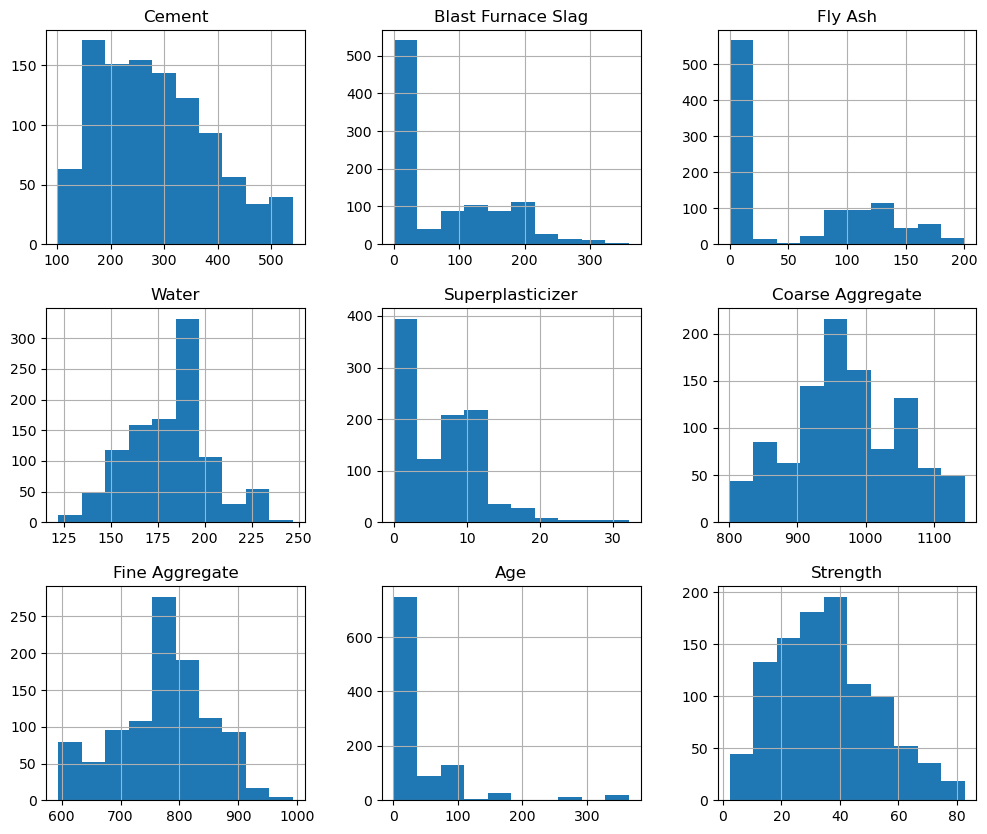

In [3]:
# 원본 데이터 세트의 분포 출력
c_df.hist(figsize=(12, 10))

- 타겟 데이터 분포의 첨도가 높지 않으니, 추가적인 전처리가 필요할 때 로그를 취할 필요는 없을 것으로 보임

In [4]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Cement                0.497832
Superplasticizer      0.366079
Age                   0.328873
Blast Furnace Slag    0.134829
Fly Ash              -0.105755
Coarse Aggregate     -0.164935
Fine Aggregate       -0.167241
Water                -0.289633
Name: Strength, dtype: float64

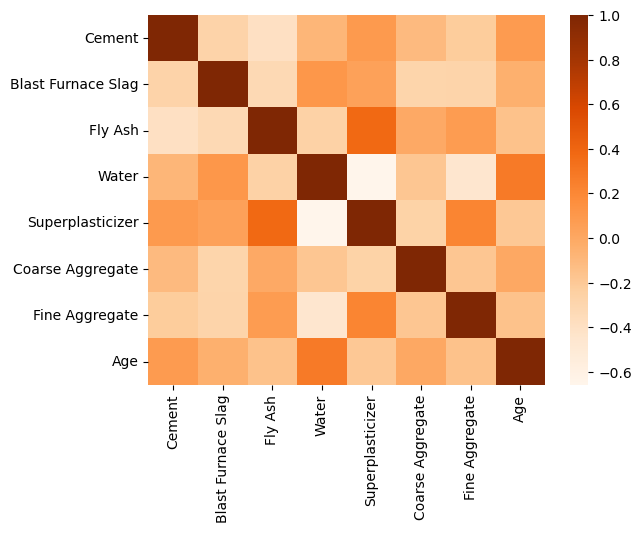

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [6]:
# feature 간 상관관계를 데이터 세트 형태로 출력
c_df.iloc[:, :-1].corr()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946
Blast Furnace Slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246
Fly Ash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371
Water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618
Superplasticizer,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700
Coarse Aggregate,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016
Fine Aggregate,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095
Age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000


### 선형 회귀 모델로 학습

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = c_df.iloc[:, :-1], c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

# 선형 회귀 모델의 평가 지표(R2 점수 포함)를 출력해주는 함수
def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, prediction))
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
          .format(MSE, RMSE, MSLE, RMSLE, R2))

MSE: 103.8526, RMSE: 10.1908, MSLE: 0.1064, RMSLE: 0.3262, R2: 0.6388


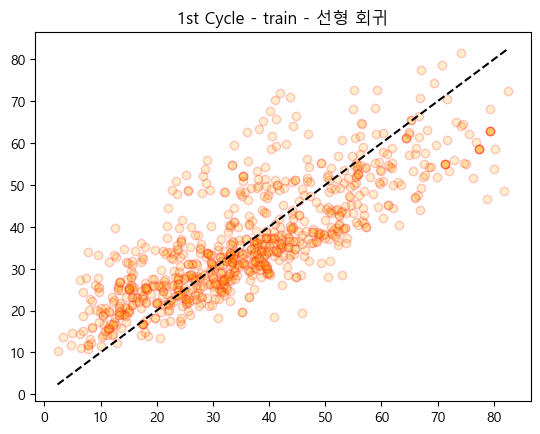

In [9]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('1st Cycle - train - 선형 회귀')
plt.show()

MSE: 123.5110, RMSE: 11.1136, MSLE: 0.1213, RMSLE: 0.3482, R2: 0.4897


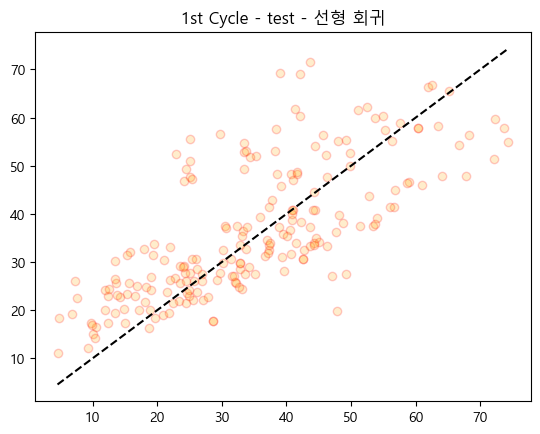

In [10]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('1st Cycle - test - 선형 회귀')
plt.show()

#### 1st Cycle - 선형 회귀 모델 학습 결과
- R2 점수가 0.5에 못 미침
- 데이터 전처리 후 재학습 진행

### 2nd Cycle - 데이터 전처리

In [11]:
# 중복 검사
c_df.duplicated().sum()

25

In [12]:
# 중복 제거한 새로운 데이터 세트 생성
pre_c_df = c_df.drop_duplicates().reset_index(drop=True)
pre_c_df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1000,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1001,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1002,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1003,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [13]:
# 결측치 검사
pre_c_df.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

array([[<Axes: title={'center': 'Cement'}>,
        <Axes: title={'center': 'Blast Furnace Slag'}>,
        <Axes: title={'center': 'Fly Ash'}>],
       [<Axes: title={'center': 'Water'}>,
        <Axes: title={'center': 'Superplasticizer'}>,
        <Axes: title={'center': 'Coarse Aggregate'}>],
       [<Axes: title={'center': 'Fine Aggregate'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Strength'}>]], dtype=object)

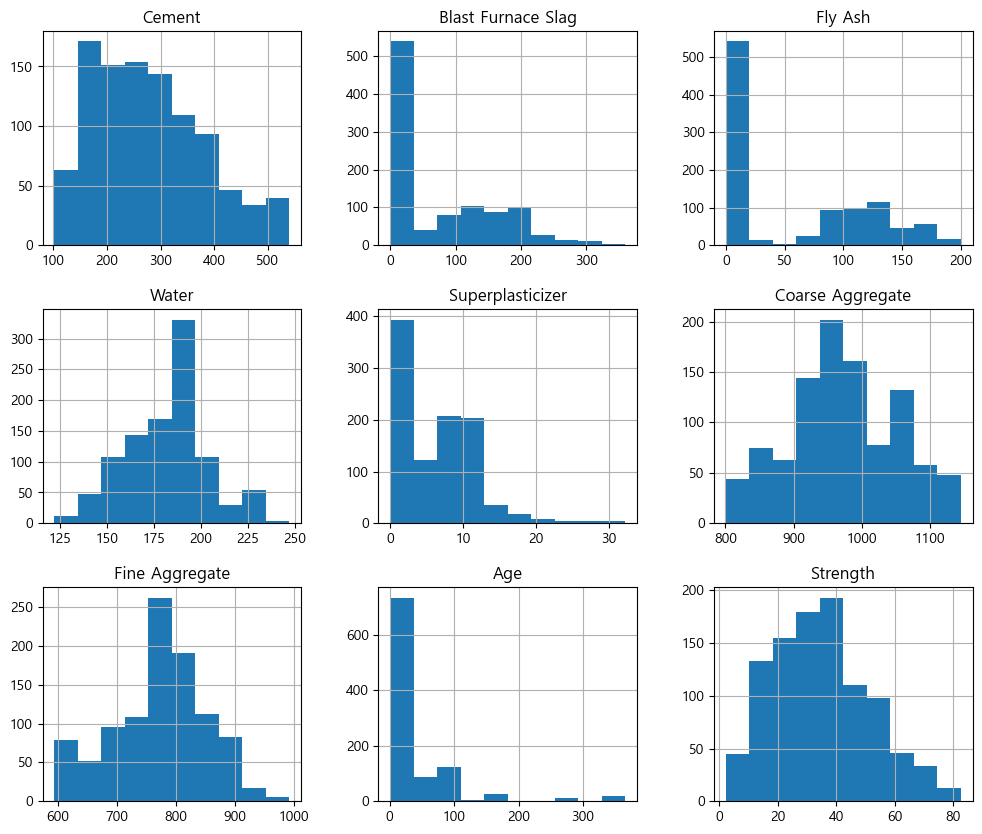

In [14]:
# 원본 데이터 세트의 분포 출력
pre_c_df.hist(figsize=(12, 10))

In [15]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
pre_c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Cement                0.488283
Superplasticizer      0.344209
Age                   0.337367
Blast Furnace Slag    0.103374
Fly Ash              -0.080648
Coarse Aggregate     -0.144717
Fine Aggregate       -0.186448
Water                -0.269624
Name: Strength, dtype: float64

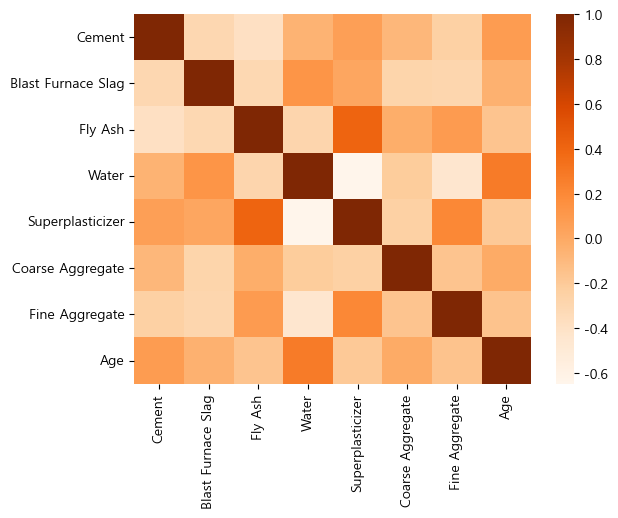

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(pre_c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [17]:
# feature 간 상관관계를 데이터 세트 형태로 출력
pre_c_df.iloc[:, :-1].corr()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Cement,1.000000,-0.303324,-0.385610,-0.056625,0.060906,-0.086205,-0.245375,0.086348
Blast Furnace Slag,-0.303324,1.000000,-0.312352,0.130262,0.019800,-0.277559,-0.289685,-0.042759
Fly Ash,-0.385610,-0.312352,1.000000,-0.283314,0.414213,-0.026468,0.090262,-0.158940
Water,-0.056625,0.130262,-0.283314,1.000000,-0.646946,-0.212480,-0.444915,0.279284
Superplasticizer,0.060906,0.019800,0.414213,-0.646946,1.000000,-0.241721,0.207993,-0.194076
Coarse Aggregate,-0.086205,-0.277559,-0.026468,-0.212480,-0.241721,1.000000,-0.162187,-0.005264
Fine Aggregate,-0.245375,-0.289685,0.090262,-0.444915,0.207993,-0.162187,1.000000,-0.156572
Age,0.086348,-0.042759,-0.158940,0.279284,-0.194076,-0.005264,-0.156572,1.000000


### 선형 회귀 모델로 학습

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = pre_c_df.iloc[:, :-1], pre_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 102.4843, RMSE: 10.1235, MSLE: 0.1113, RMSLE: 0.3336, R2: 0.6166


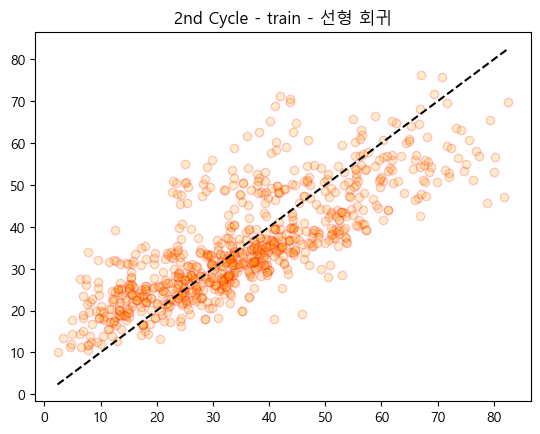

In [19]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('2nd Cycle - train - 선형 회귀')
plt.show()

MSE: 116.2002, RMSE: 10.7796, MSLE: 0.1056, RMSLE: 0.3250, R2: 0.5443


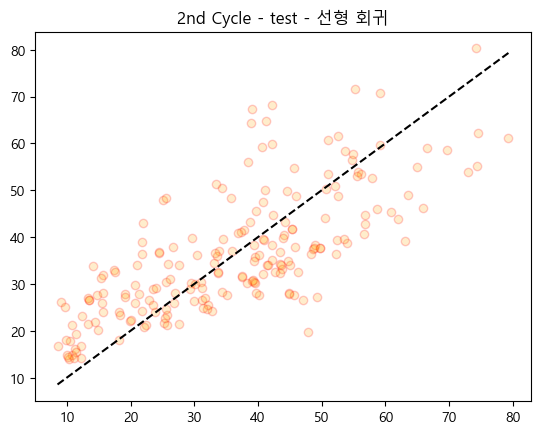

In [20]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('2nd Cycle - test - 선형 회귀')
plt.show()

#### 2nd Cycle - 선형 회귀 모델 학습 결과
- 이전 사이클에 비해 R2 점수가 향상된 것을 확인
- 데이터 표준화 후 이상치를 제거했을 때 생기는 변화와 비교해보기

### 3nd Cycle - 데이터 전처리
- StandardScaler()로 수치형 데이터 표준화
- 표준화 이후 수치가 -1.96 ~ 1.96이 아닌 데이터들 제거

In [21]:
from sklearn.preprocessing import StandardScaler

# 표준화 된 수치가 담긴 데이터 세트를 새로 생성
std = StandardScaler()
result = std.fit_transform(pre_c_df)
std_pre_c_df = pd.DataFrame(result, columns=pre_c_df.columns)
std_pre_c_df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,2.506116,-0.836471,-0.865375,-0.941235,-0.597131,0.846302,-1.204081,-0.280312,2.748689
1,2.506116,-0.836471,-0.865375,-0.941235,-0.597131,1.039748,-1.204081,-0.280312,1.636671
2,0.516516,0.818045,-0.865375,2.153185,-1.019640,-0.546508,-2.225246,3.518569,0.308393
3,0.516516,0.818045,-0.865375,2.153185,-1.019640,-0.546508,-2.225246,5.009865,0.356314
4,-0.767375,0.700778,-0.865375,0.465320,-1.019640,0.051885,0.657677,4.931375,0.555986
...,...,...,...,...,...,...,...,...,...
1000,-0.021395,0.510363,0.541693,-0.116056,0.484495,-1.344795,-0.054648,-0.280312,0.554757
1001,0.417755,-0.836471,0.935921,0.652861,0.738001,-2.017987,0.506993,-0.280312,-0.250074
1002,-1.247756,0.782052,0.826846,0.498140,0.011284,-1.057205,0.091055,-0.280312,-0.709626
1003,-1.146118,1.331235,-0.865375,-0.303597,0.890104,0.196324,0.201889,-0.280312,-0.152388


In [22]:
condition = True

# 반복문으로 각 컬럼에서 -1.96 ~ 1.96 사이의 데이터만 가져오는 조건식 생성
for column in std_pre_c_df.columns:
    condition &= std_pre_c_df[column].between(-1.96, 1.96)

# 위 조건에 맞지 않는 데이터 삭제
std_pre_c_df = std_pre_c_df[condition]
std_pre_c_df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
10,-0.767375,0.700778,-0.865375,0.465320,-1.019640,0.051885,0.657677,0.692955,0.173230
11,-0.767375,0.700778,-0.865375,0.465320,-1.019640,0.051885,0.657677,-0.280312,-0.444216
16,-1.333093,1.594797,-0.865375,0.465320,-1.019640,0.936577,0.426047,0.692955,0.252485
21,-1.333093,1.594797,-0.865375,0.465320,-1.019640,0.936577,0.426047,-0.280312,-0.430700
22,-1.333093,1.594797,-0.865375,0.465320,-1.019640,0.936577,0.426047,-0.672758,-1.670508
...,...,...,...,...,...,...,...,...,...
997,-0.135497,0.452310,0.482481,0.629418,-0.022517,-1.828410,0.220568,-0.280312,0.386418
1000,-0.021395,0.510363,0.541693,-0.116056,0.484495,-1.344795,-0.054648,-0.280312,0.554757
1002,-1.247756,0.782052,0.826846,0.498140,0.011284,-1.057205,0.091055,-0.280312,-0.709626
1003,-1.146118,1.331235,-0.865375,-0.303597,0.890104,0.196324,0.201889,-0.280312,-0.152388


In [23]:
# pre_c_df에서 이상치가 없는 인덱스만 유지하고, 인덱스 초기화
pre_c_df = pre_c_df.iloc[std_pre_c_df.index].reset_index(drop=True)
pre_c_df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,198.6,132.4,0.0,192.0,0.0,978.4,825.5,90,38.07
1,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28,28.02
2,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,90,39.36
3,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,28,28.24
4,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,3,8.06
...,...,...,...,...,...,...,...,...,...
715,264.5,111.0,86.5,195.5,5.9,832.6,790.4,28,41.54
716,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
717,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
718,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


array([[<Axes: title={'center': 'Cement'}>,
        <Axes: title={'center': 'Blast Furnace Slag'}>,
        <Axes: title={'center': 'Fly Ash'}>],
       [<Axes: title={'center': 'Water'}>,
        <Axes: title={'center': 'Superplasticizer'}>,
        <Axes: title={'center': 'Coarse Aggregate'}>],
       [<Axes: title={'center': 'Fine Aggregate'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Strength'}>]], dtype=object)

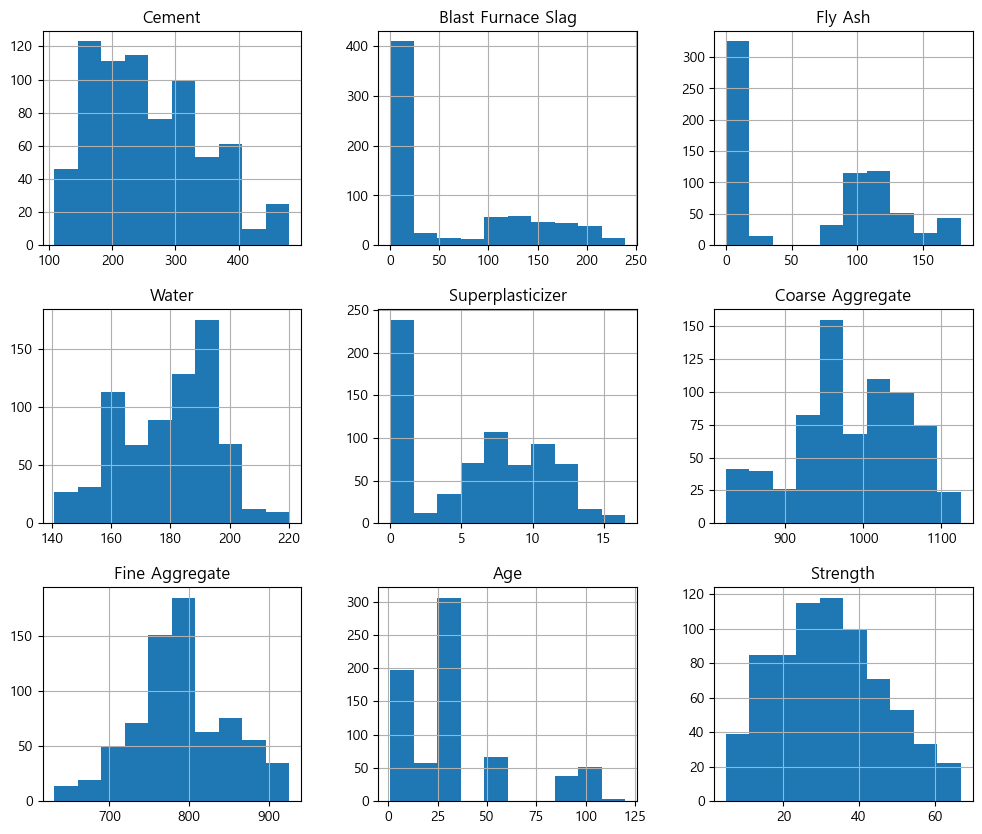

In [24]:
# 원본 데이터 세트의 분포 출력
pre_c_df.hist(figsize=(12, 10))

In [25]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
pre_c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Age                   0.567925
Superplasticizer      0.441279
Cement                0.326046
Fly Ash               0.124221
Blast Furnace Slag    0.093006
Fine Aggregate       -0.104157
Coarse Aggregate     -0.191517
Water                -0.389538
Name: Strength, dtype: float64

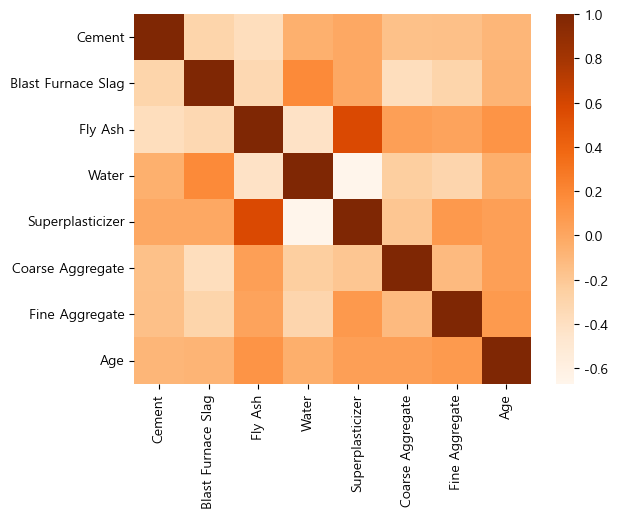

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(pre_c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [27]:
# feature 간 상관관계를 데이터 세트 형태로 출력
pre_c_df.iloc[:, :-1].corr()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Cement,1.000000,-0.296936,-0.378685,-0.051506,-0.009158,-0.160193,-0.151530,-0.092379
Blast Furnace Slag,-0.296936,1.000000,-0.324692,0.179947,-0.006695,-0.379349,-0.293065,-0.077498
Fly Ash,-0.378685,-0.324692,1.000000,-0.417051,0.569877,0.053390,0.024300,0.122548
Water,-0.051506,0.179947,-0.417051,1.000000,-0.669075,-0.241992,-0.298933,-0.046674
Superplasticizer,-0.009158,-0.006695,0.569877,-0.669075,1.000000,-0.186904,0.091230,0.049983
Coarse Aggregate,-0.160193,-0.379349,0.053390,-0.241992,-0.186904,1.000000,-0.119828,0.052986
Fine Aggregate,-0.151530,-0.293065,0.024300,-0.298933,0.091230,-0.119828,1.000000,0.086554
Age,-0.092379,-0.077498,0.122548,-0.046674,0.049983,0.052986,0.086554,1.000000


### 선형 회귀 모델로 학습

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = pre_c_df.iloc[:, :-1], pre_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 49.0203, RMSE: 7.0015, MSLE: 0.0605, RMSLE: 0.2459, R2: 0.7614


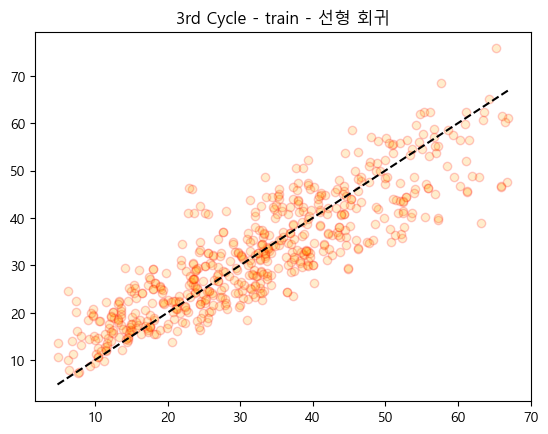

In [29]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('3rd Cycle - train - 선형 회귀')
plt.show()

MSE: 49.6105, RMSE: 7.0435, MSLE: 0.0594, RMSLE: 0.2438, R2: 0.7435


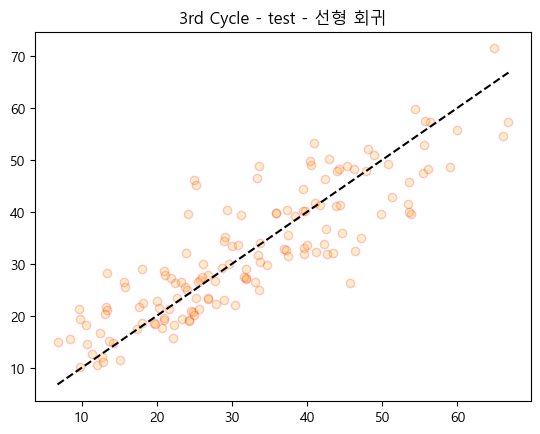

In [30]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('3rd Cycle - test - 선형 회귀')
plt.show()

#### 3rd Cycle - 선형 회귀 모델 학습 결과
- R2 Score가 만족스러운 수준까지 향상됨
- Polynomial, OLS, VIF 등을 활용해서 더욱 나은 성능의 모델을 구현해보기

### Polynomial(다항 회귀) 학습

In [31]:
from sklearn.preprocessing import PolynomialFeatures

# 다항 회귀: degree는 차수를 의미함
poly_features = PolynomialFeatures(degree=2).fit_transform(features)
poly_features

array([[1.0000000e+00, 1.9860000e+02, 1.3240000e+02, ..., 6.8145025e+05,
        7.4295000e+04, 8.1000000e+03],
       [1.0000000e+00, 1.9860000e+02, 1.3240000e+02, ..., 6.8145025e+05,
        2.3114000e+04, 7.8400000e+02],
       [1.0000000e+00, 1.3960000e+02, 2.0940000e+02, ..., 6.5108761e+05,
        7.2621000e+04, 8.1000000e+03],
       ...,
       [1.0000000e+00, 1.4850000e+02, 1.3940000e+02, ..., 6.0840000e+05,
        2.1840000e+04, 7.8400000e+02],
       [1.0000000e+00, 1.5910000e+02, 1.8670000e+02, ..., 6.2236321e+05,
        2.2089200e+04, 7.8400000e+02],
       [1.0000000e+00, 2.6090000e+02, 1.0050000e+02, ..., 5.7988225e+05,
        2.1322000e+04, 7.8400000e+02]])

In [32]:
X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 23.0885, RMSE: 4.8050, MSLE: 0.0310, RMSLE: 0.1760, R2: 0.8876


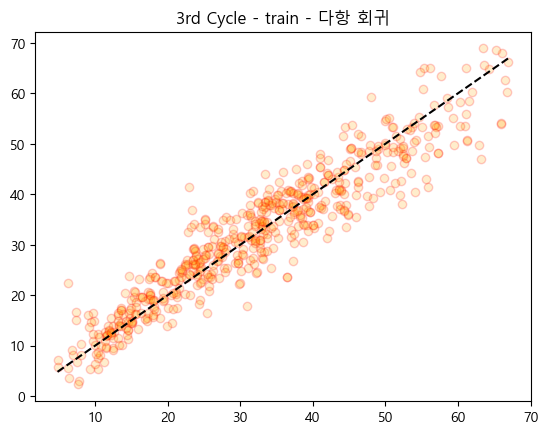

In [33]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('3rd Cycle - train - 다항 회귀')
plt.show()

MSE: 25.7876, RMSE: 5.0781, MSLE: 0.0294, RMSLE: 0.1714, R2: 0.8667


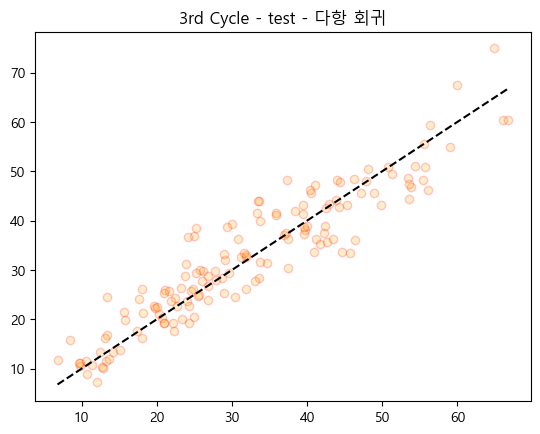

In [34]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('3rd Cycle - test - 다항 회귀')
plt.show()

#### 3rd Cycle - 다항 회귀 모델 학습 결과
- 회귀선의 차수가 2일 때 R2가 0.8667까지 향상됨
- 선형 회귀 모델보다 높은 R2를 보임에 따라, 현재 데이터가 비선형이라고 할 수 있음
- 아래에서 트리 회귀 모델 학습 결과와 비교 분석하면서 가장 높은 성능을 보인 모델 찾아보기

### 각종 회귀 모델로 학습

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = pre_c_df.iloc[:, :-1], pre_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 회귀모델 선언
# 주의: poly랑 병행하지 말 것
dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=100)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor()
lgb_r = LGBMRegressor(n_estimators=100)

# 반복문으로 fit하기 위해 list 안에 담기
models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]

for model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(model.__class__.__name__)
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 32.3654, RMSE: 5.6891, MSLE: 0.0472, RMSLE: 0.2172, R2: 0.8327
RandomForestRegressor
MSE: 19.6409, RMSE: 4.4318, MSLE: 0.0265, RMSLE: 0.1626, R2: 0.8985
GradientBoostingRegressor
MSE: 20.8236, RMSE: 4.5633, MSLE: 0.0277, RMSLE: 0.1663, R2: 0.8923
XGBRegressor
MSE: 17.0724, RMSE: 4.1319, MSLE: 0.0216, RMSLE: 0.1471, R2: 0.9117
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 8
[LightGBM] [Info] Start training from score 32.236667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

#### 3rd Cycle - 각종 회귀 모델 학습 결과
- 전반적으로 R2가 0.8 이상으로, 우수한 결과를 보여줌
- 단, 과적합 발생 가능성도 존재하니 VIF와 pairplot으로 다중 공선성 발생 여부 확인

### VIF Score 출력

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# feature 별 VIF Score를 출력해주는 함수
def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['feature'] = features.columns
    return vif

In [37]:
# feature 별 VIF Score 출력
get_vif(features)

,vif_score,feature
0,18.189222,Cement
1,3.313920,Blast Furnace Slag
2,6.222276,Fly Ash
3,131.798549,Water
4,7.501128,Superplasticizer
5,116.571303,Coarse Aggregate
6,124.096826,Fine Aggregate
7,2.289399,Age


#### 중간 분석
- Water와 Coarse Aggregate, Fine Aggregate에서 VIF Score가 매우 높은 수치를 보임
- 또한 Cement 역시 10 이상의 높은 수치를 보여줌

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

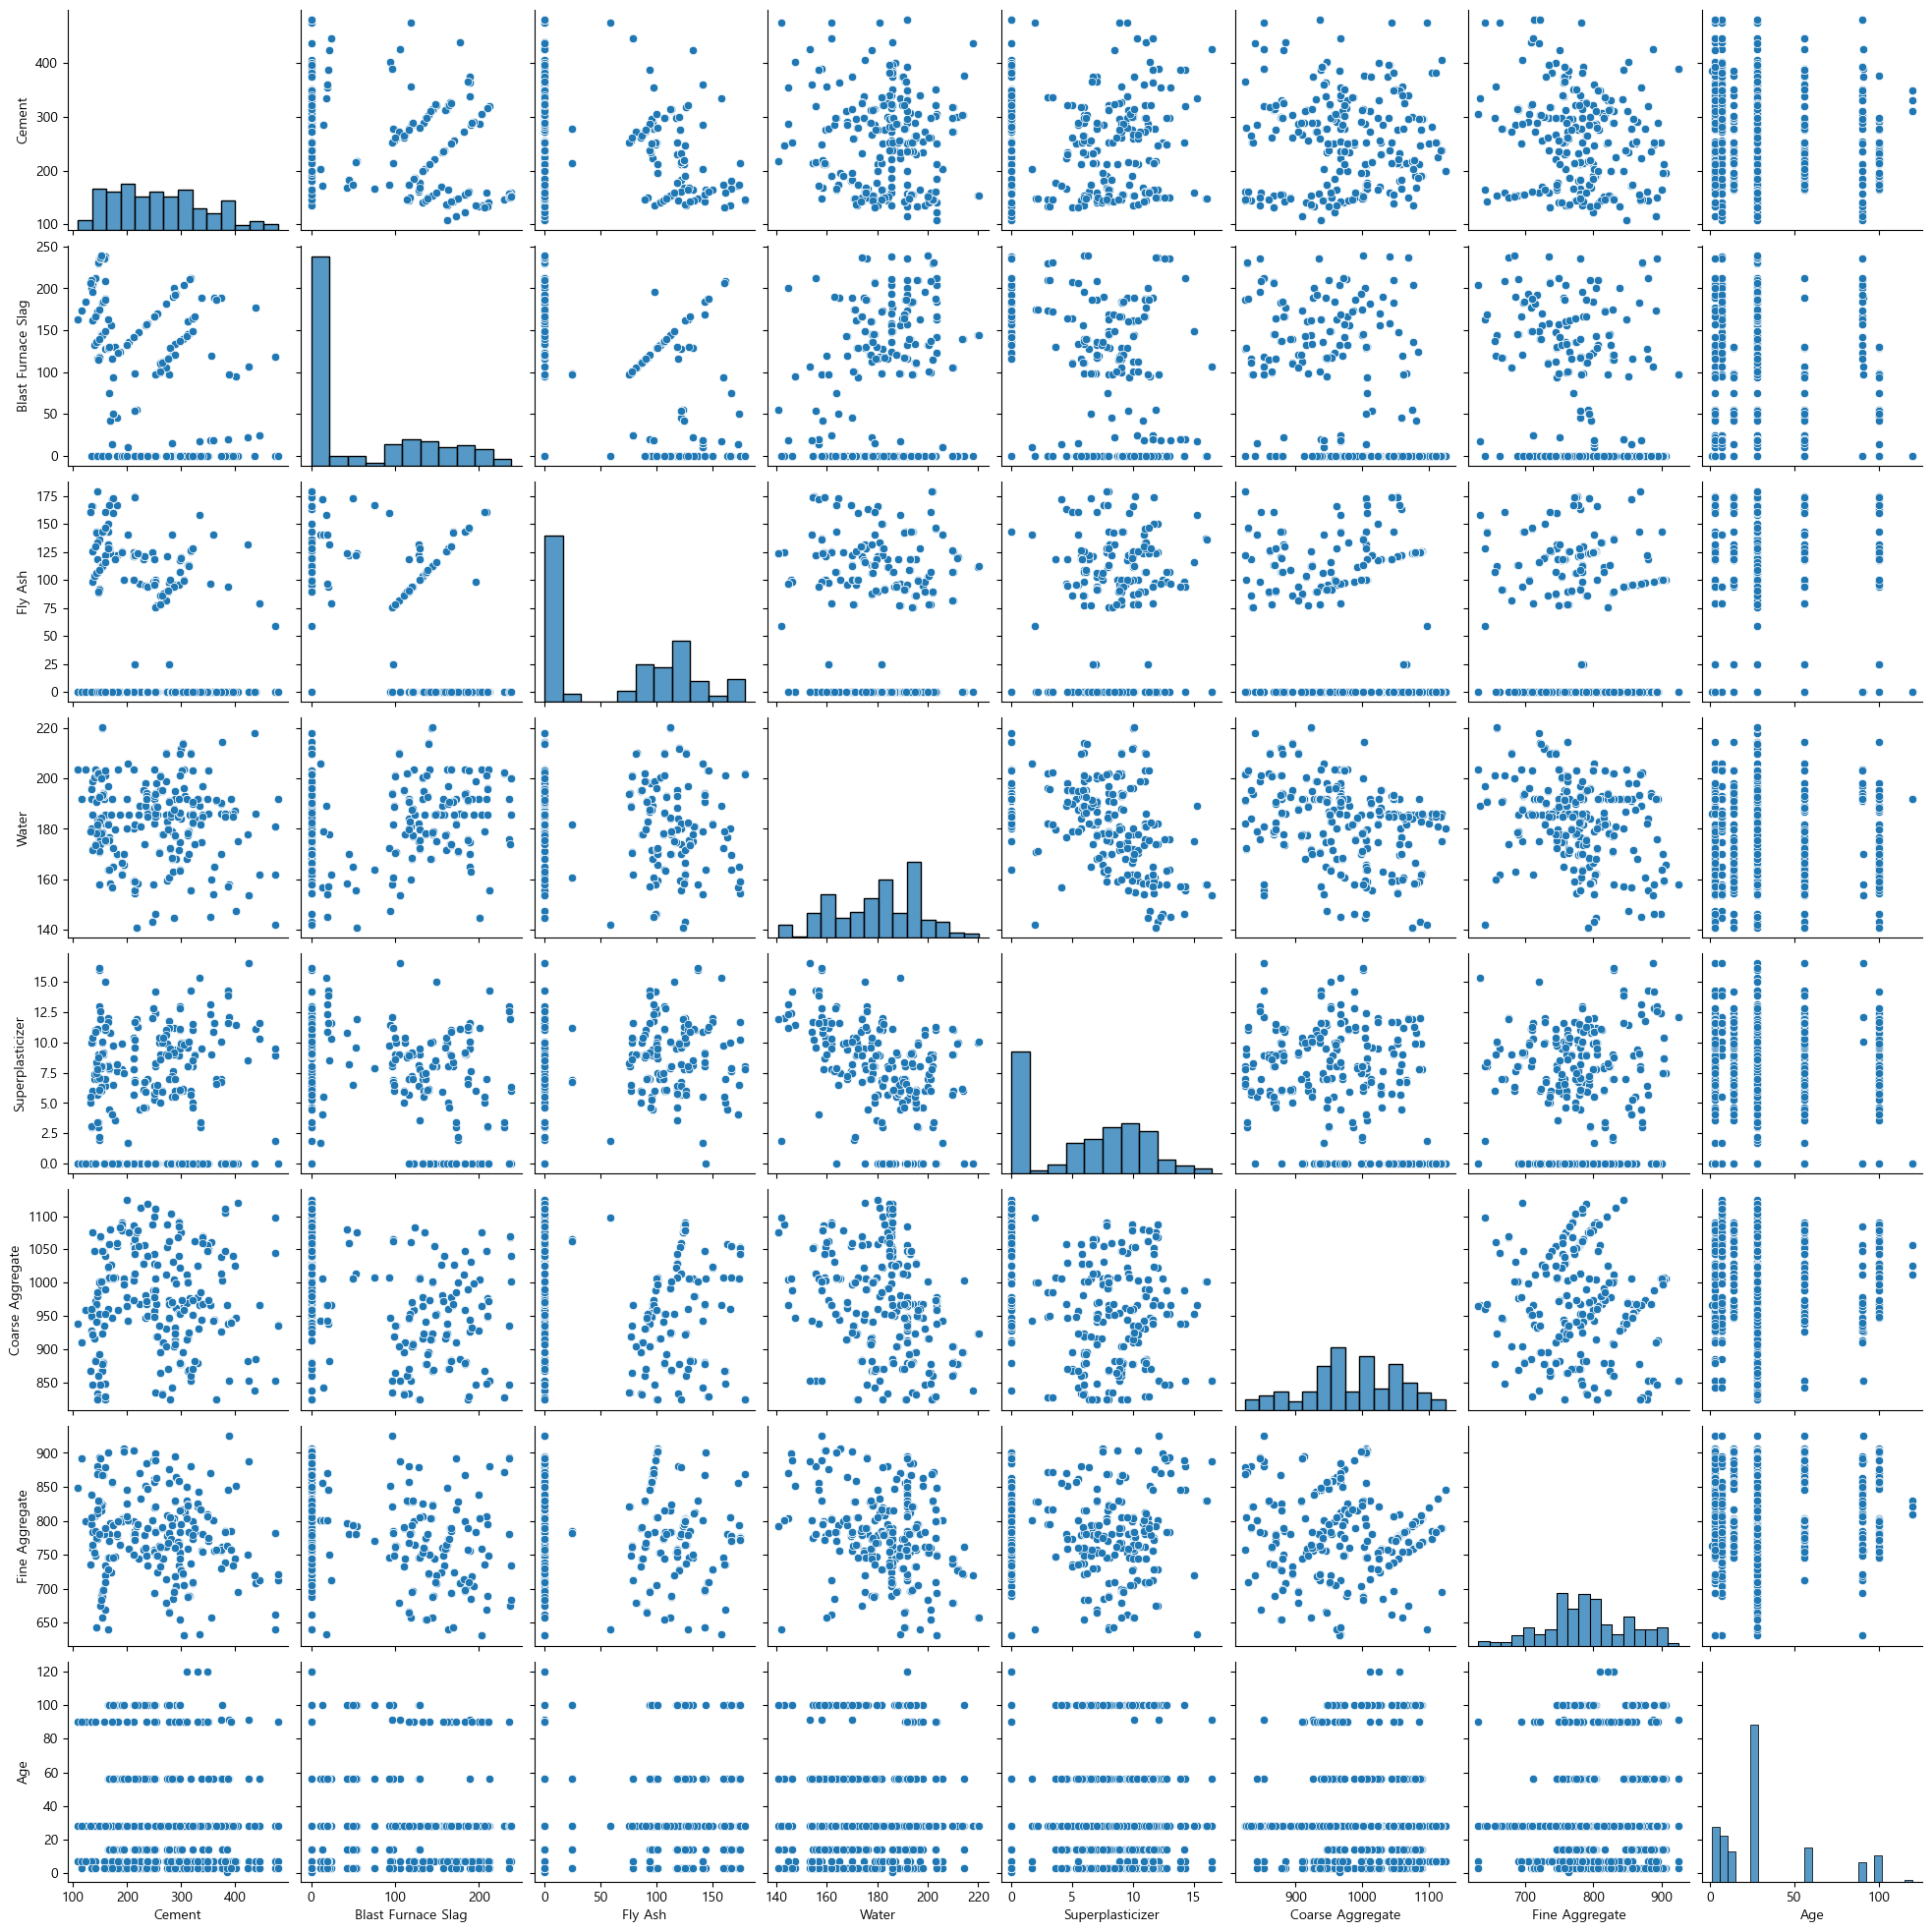

In [38]:
# 다중공선성 존재 여부를 확인하기 위해 pairplot 시각화
sns.pairplot(features)
plt.show()

#### 3rd Cycle - VIF Score 출력 결과
- 4개의 feature에서 높은 다중 공선성이 확인됨
- 아래의 OLS 평가와 종합해서 제거할 feature 선정

### OLS 평가

In [39]:
from statsmodels.api import OLS

# 현재 데이터의 OLS 평가
model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Strength   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              2128.
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        23:37:02   Log-Likelihood:                         -2428.3
No. Observations:                 720   AIC:                                      4873.
Df Residuals:                     712   BIC:                                      4909.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

#### 3rd Cycle - OLS 출력 결과
- Fine Aggregate가 target에 미치는 영향이 적은 것으로 확인됨에 따라 다음 사이클에서는 제거

### 4th Cycle
- corr(), VIF, OLS를 종합했을 때 삭제할 feature들
> - Fly Ash: Superplasticizer와의 상관관계가 높지만, target과의 상관관계는 낮음
> - Fine Aggregate: target에 미치는 영향력이 낮음

- 이번 사이클 결과 보고 추후 전처리 방향 판단

### 4th Cycle - 데이터 전처리

In [40]:
# 이전 사이클 때 사용한 데이터 세트에서 FLy Ash와 Fine Aggregate를 제거한 새로운 데이터 세트 생성
fourth_c_df = pre_c_df.drop(labels=['Fly Ash', 'Fine Aggregate'], axis=1)
fourth_c_df

,Cement,Blast Furnace Slag,Water,Superplasticizer,Coarse Aggregate,Age,Strength
0,198.6,132.4,192.0,0.0,978.4,90,38.07
1,198.6,132.4,192.0,0.0,978.4,28,28.02
2,139.6,209.4,192.0,0.0,1047.0,90,39.36
3,139.6,209.4,192.0,0.0,1047.0,28,28.24
4,139.6,209.4,192.0,0.0,1047.0,3,8.06
...,...,...,...,...,...,...,...
715,264.5,111.0,195.5,5.9,832.6,28,41.54
716,276.4,116.0,179.6,8.9,870.1,28,44.28
717,148.5,139.4,192.7,6.1,892.4,28,23.70
718,159.1,186.7,175.6,11.3,989.6,28,32.77


In [41]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
fourth_c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Age                   0.567925
Superplasticizer      0.441279
Cement                0.326046
Blast Furnace Slag    0.093006
Coarse Aggregate     -0.191517
Water                -0.389538
Name: Strength, dtype: float64

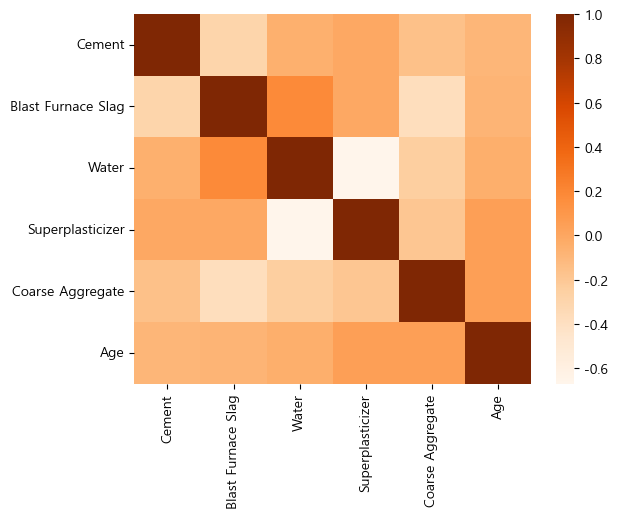

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(fourth_c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [43]:
# feature 간 상관관계를 데이터 세트 형태로 출력
fourth_c_df.iloc[:, :-1].corr()

,Cement,Blast Furnace Slag,Water,Superplasticizer,Coarse Aggregate,Age
Cement,1.000000,-0.296936,-0.051506,-0.009158,-0.160193,-0.092379
Blast Furnace Slag,-0.296936,1.000000,0.179947,-0.006695,-0.379349,-0.077498
Water,-0.051506,0.179947,1.000000,-0.669075,-0.241992,-0.046674
Superplasticizer,-0.009158,-0.006695,-0.669075,1.000000,-0.186904,0.049983
Coarse Aggregate,-0.160193,-0.379349,-0.241992,-0.186904,1.000000,0.052986
Age,-0.092379,-0.077498,-0.046674,0.049983,0.052986,1.000000


### 선형 회귀 모델로 학습

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = fourth_c_df.iloc[:, :-1], fourth_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 53.4872, RMSE: 7.3135, MSLE: 0.0664, RMSLE: 0.2577, R2: 0.7397


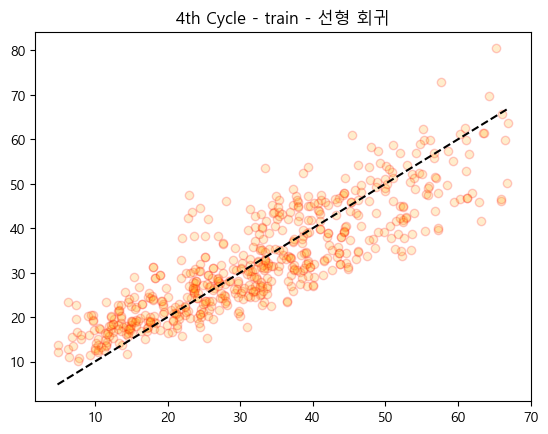

In [45]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('4th Cycle - train - 선형 회귀')
plt.show()

MSE: 54.8989, RMSE: 7.4094, MSLE: 0.0624, RMSLE: 0.2499, R2: 0.7162


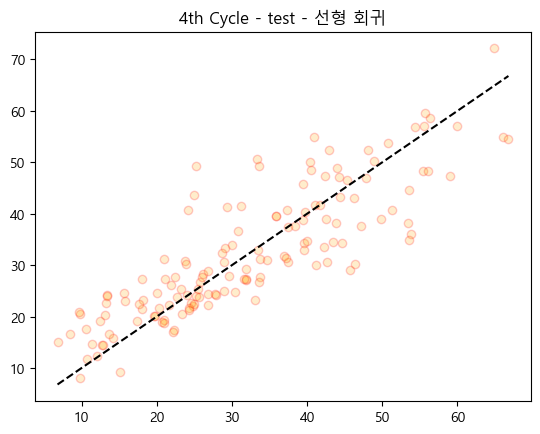

In [46]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('4th Cycle - test - 선형 회귀')
plt.show()

#### 4th Cycle - 선형 회귀 모델 학습 결과
- 이전 사이클에 비해 R2 Score가 약간 감소함
- 모델의 성능이 떨어졌거나, 비선형의 성격이 강해진 것이 원인으로 추정됨

### Polynomial(다항 회귀) 학습

In [47]:
from sklearn.preprocessing import PolynomialFeatures

# 다항 회귀: degree는 차수를 의미함
poly_features = PolynomialFeatures(degree=2).fit_transform(features)
poly_features

array([[1.0000000e+00, 1.9860000e+02, 1.3240000e+02, ..., 9.5726656e+05,
        8.8056000e+04, 8.1000000e+03],
       [1.0000000e+00, 1.9860000e+02, 1.3240000e+02, ..., 9.5726656e+05,
        2.7395200e+04, 7.8400000e+02],
       [1.0000000e+00, 1.3960000e+02, 2.0940000e+02, ..., 1.0962090e+06,
        9.4230000e+04, 8.1000000e+03],
       ...,
       [1.0000000e+00, 1.4850000e+02, 1.3940000e+02, ..., 7.9637776e+05,
        2.4987200e+04, 7.8400000e+02],
       [1.0000000e+00, 1.5910000e+02, 1.8670000e+02, ..., 9.7930816e+05,
        2.7708800e+04, 7.8400000e+02],
       [1.0000000e+00, 2.6090000e+02, 1.0050000e+02, ..., 7.4736025e+05,
        2.4206000e+04, 7.8400000e+02]])

In [48]:
X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 26.8273, RMSE: 5.1795, MSLE: 0.0346, RMSLE: 0.1859, R2: 0.8694


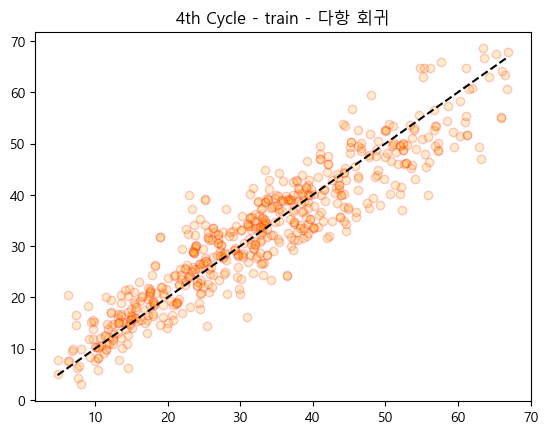

In [49]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('4th Cycle - train - 다항 회귀')
plt.show()

MSE: 28.8762, RMSE: 5.3737, MSLE: 0.0403, RMSLE: 0.2007, R2: 0.8507


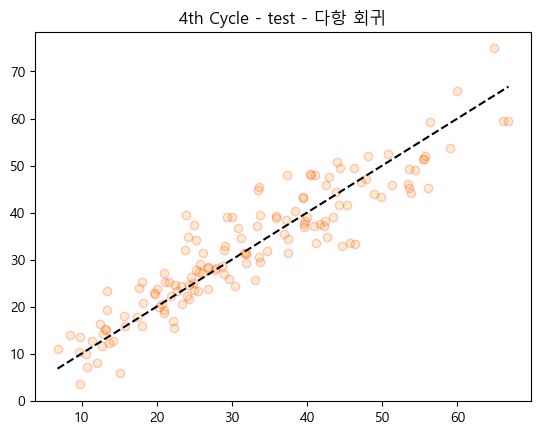

In [50]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('4th Cycle - test - 다항 회귀')
plt.show()

#### 4th Cycle - 다항 회귀 모델 학습 결과
- 이전 사이클과 마찬가지로, 회귀선의 차수가 2일 때 가장 높은 R2를 보임
- 단, 이전 사이클에 비해 R2가 약간 감소함에 따라 모델의 예측 성능이 감소한 것으로 추정

### 각종 회귀 모델로 학습

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = fourth_c_df.iloc[:, :-1], fourth_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 회귀모델 선언
# 주의: poly랑 병행하지 말 것
dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=100)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor()
lgb_r = LGBMRegressor(n_estimators=100)

# 반복문으로 fit하기 위해 list 안에 담기
models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]

for model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(model.__class__.__name__)
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 28.9042, RMSE: 5.3763, MSLE: 0.0367, RMSLE: 0.1916, R2: 0.8506
RandomForestRegressor
MSE: 18.8250, RMSE: 4.3388, MSLE: 0.0242, RMSLE: 0.1554, R2: 0.9027
GradientBoostingRegressor
MSE: 18.8043, RMSE: 4.3364, MSLE: 0.0245, RMSLE: 0.1566, R2: 0.9028
XGBRegressor
MSE: 14.0006, RMSE: 3.7417, MSLE: 0.0188, RMSLE: 0.1371, R2: 0.9276
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 6
[LightGBM] [Info] Start training from score 32.236667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

#### 4th Cycle - 각종 회귀 모델 학습 결과
- 이전 사이클과는 다르게, XGB 회귀 모델의 R2가 가장 높게 측정됨
- VIF와 pairplot으로 다중공선성 여부 확인해보기

### VIF Score 출력

In [52]:
# feature 별 VIF Score 출력
get_vif(features)

,vif_score,feature
0,10.808224,Cement
1,2.060830,Blast Furnace Slag
2,91.060257,Water
3,2.868769,Superplasticizer
4,84.965223,Coarse Aggregate
5,2.276336,Age


#### 중간 분석
- Water와 Coarse Aggregate, Cement가 여전히 높은 VIF Score를 보임

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

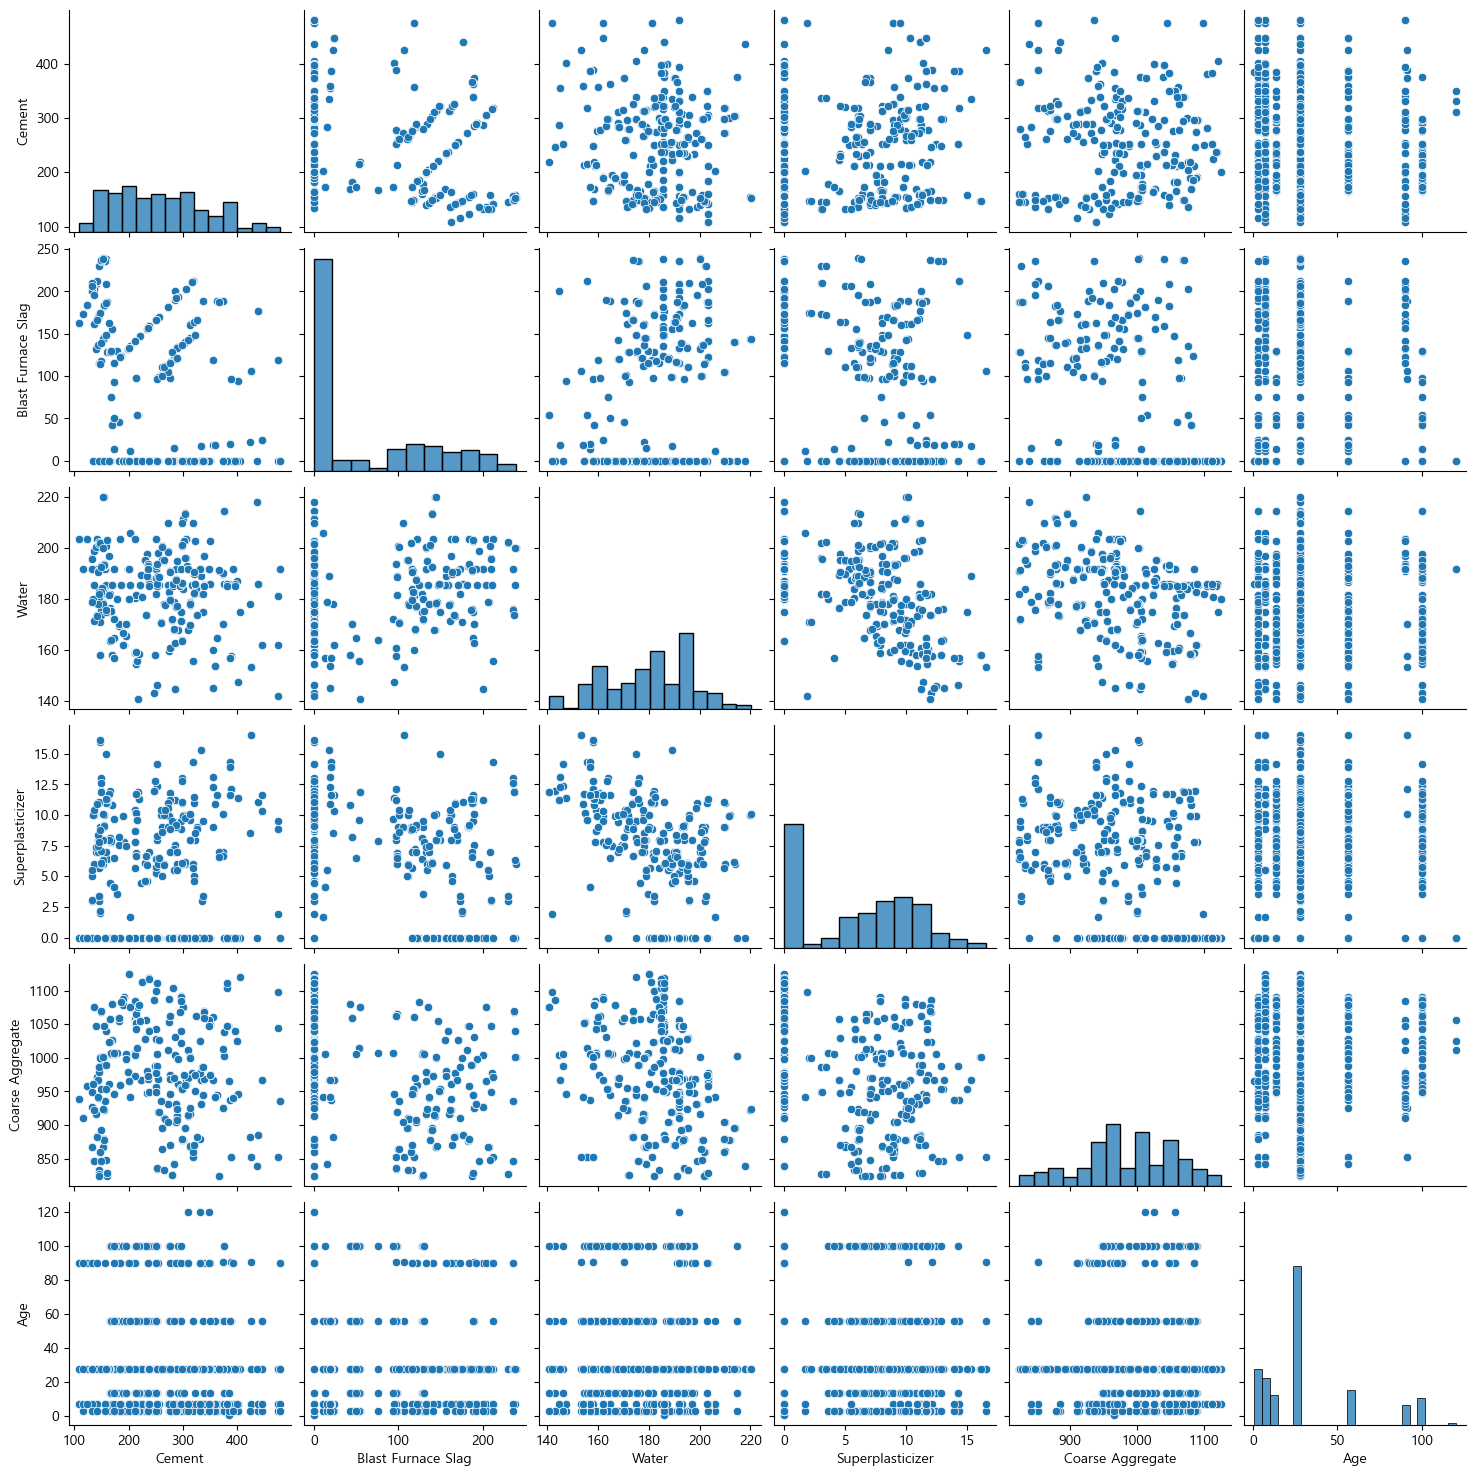

In [53]:
# 다중공선성 존재 여부를 확인하기 위해 pairplot 시각화
sns.pairplot(features)
plt.show()

#### 4th Cycle - VIF Score 출력 결과
- 3개의 feature에서 높은 다중 공선성이 확인됨
- 아래의 OLS 평가와 종합해서 제거할 feature 선정

### OLS 평가

In [54]:
from statsmodels.api import OLS

# 현재 데이터의 OLS 평가
model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Strength   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              2554.
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        23:37:09   Log-Likelihood:                         -2465.5
No. Observations:                 720   AIC:                                      4943.
Df Residuals:                     714   BIC:                                      4970.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

#### 4th Cycle - OLS 출력 결과
- 타겟에 영향이 적은 feature는 찾지 못함
- 따라서 위의 corr()과 VIF만 참고하여 다음 사이클에서 제거할 feature 선정

### 5th Cycle - 데이터 전처리
- 이전 사이클에서 사용한 데이터 세트를 기반으로 일부 feature 제거 후 테스트
> - Blast Furnace Slag: 타겟과의 상관관계 낮음
> - Water: VIF Score가 높고, Superplasticizer와 음의 상관관계 높음

In [55]:
# 이전 사이클의 데이터 세트에서 일부 feature를 제거한 새로운 데이터 세트 생성
fifth_c_df = fourth_c_df.drop(labels=['Blast Furnace Slag', 'Water'], axis=1)
fifth_c_df

,Cement,Superplasticizer,Coarse Aggregate,Age,Strength
0,198.6,0.0,978.4,90,38.07
1,198.6,0.0,978.4,28,28.02
2,139.6,0.0,1047.0,90,39.36
3,139.6,0.0,1047.0,28,28.24
4,139.6,0.0,1047.0,3,8.06
...,...,...,...,...,...
715,264.5,5.9,832.6,28,41.54
716,276.4,8.9,870.1,28,44.28
717,148.5,6.1,892.4,28,23.70
718,159.1,11.3,989.6,28,32.77


In [56]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
fifth_c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Age                 0.567925
Superplasticizer    0.441279
Cement              0.326046
Coarse Aggregate   -0.191517
Name: Strength, dtype: float64

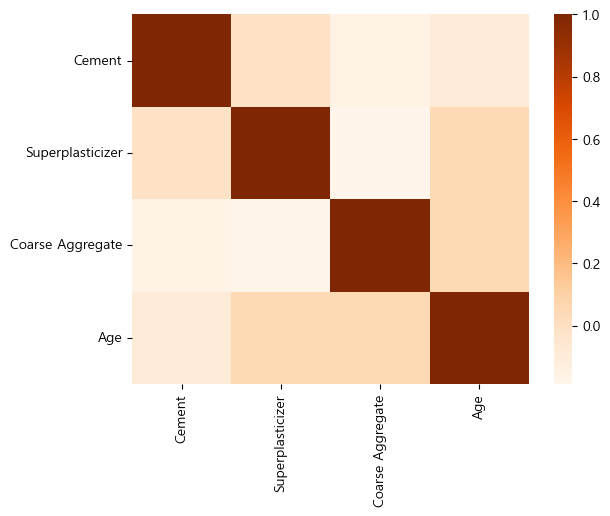

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(fifth_c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [58]:
# feature 간 상관관계를 데이터 세트 형태로 출력
fifth_c_df.iloc[:, :-1].corr()

,Cement,Superplasticizer,Coarse Aggregate,Age
Cement,1.000000,-0.009158,-0.160193,-0.092379
Superplasticizer,-0.009158,1.000000,-0.186904,0.049983
Coarse Aggregate,-0.160193,-0.186904,1.000000,0.052986
Age,-0.092379,0.049983,0.052986,1.000000


#### 5th Cycle - 상관관계 시각화 결과
- 이전 사이클까지 존재했던 일부 feature 사이의 높은 상관관계가 해소됨
- 이에 따라 우수한 학습 결과를 얻을 수 있을 것으로 기대

### 선형 회귀 모델로 학습

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = fifth_c_df.iloc[:, :-1], fifth_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 71.7848, RMSE: 8.4726, MSLE: 0.0870, RMSLE: 0.2949, R2: 0.6507


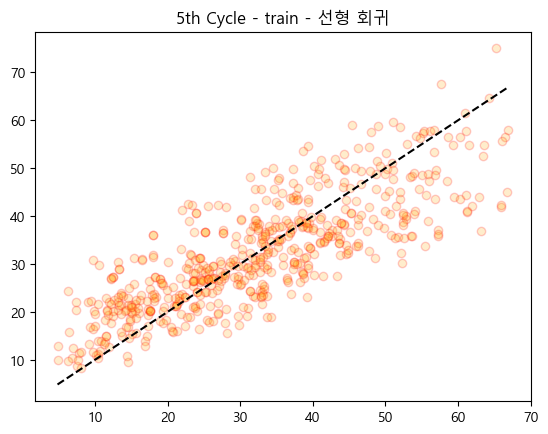

In [60]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('5th Cycle - train - 선형 회귀')
plt.show()

MSE: 71.7580, RMSE: 8.4710, MSLE: 0.0832, RMSLE: 0.2884, R2: 0.6290


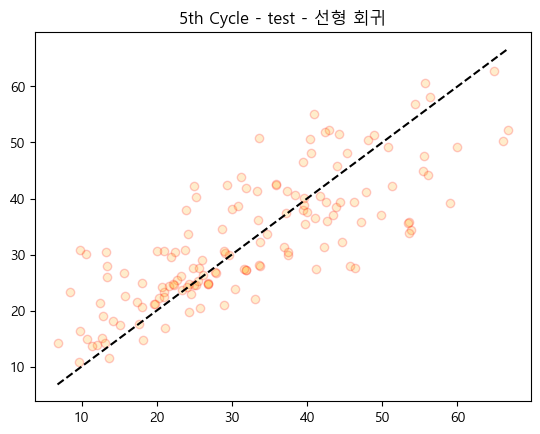

In [61]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('5th Cycle - test - 선형 회귀')
plt.show()

#### 5th Cycle - 선형 회귀 모델 학습 결과
- 이전 사이클에 비해 R2 Score가 더욱 감소함
- 이는 타겟과의 상관관계가 높았던 Water를 제거해서 발생한 현상으로 추정

### Polynomial(다항 회귀) 학습

In [62]:
from sklearn.preprocessing import PolynomialFeatures

# 다항 회귀: degree는 차수를 의미함
poly_features = PolynomialFeatures(degree=2).fit_transform(features)
poly_features

array([[1.0000000e+00, 1.9860000e+02, 0.0000000e+00, ..., 9.5726656e+05,
        8.8056000e+04, 8.1000000e+03],
       [1.0000000e+00, 1.9860000e+02, 0.0000000e+00, ..., 9.5726656e+05,
        2.7395200e+04, 7.8400000e+02],
       [1.0000000e+00, 1.3960000e+02, 0.0000000e+00, ..., 1.0962090e+06,
        9.4230000e+04, 8.1000000e+03],
       ...,
       [1.0000000e+00, 1.4850000e+02, 6.1000000e+00, ..., 7.9637776e+05,
        2.4987200e+04, 7.8400000e+02],
       [1.0000000e+00, 1.5910000e+02, 1.1300000e+01, ..., 9.7930816e+05,
        2.7708800e+04, 7.8400000e+02],
       [1.0000000e+00, 2.6090000e+02, 8.6000000e+00, ..., 7.4736025e+05,
        2.4206000e+04, 7.8400000e+02]])

In [63]:
X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 52.3742, RMSE: 7.2370, MSLE: 0.0652, RMSLE: 0.2553, R2: 0.7451


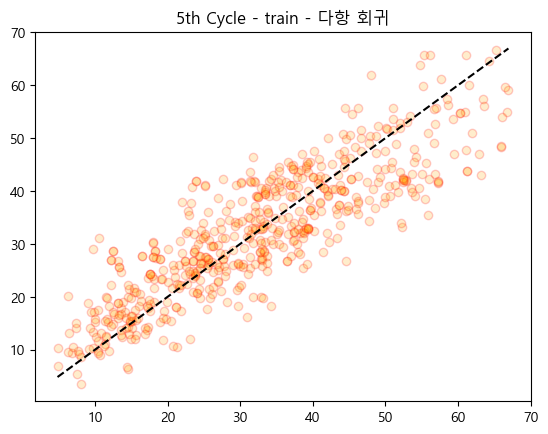

In [64]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('5th Cycle - train - 다항 회귀')
plt.show()

MSE: 53.0961, RMSE: 7.2867, MSLE: 0.0602, RMSLE: 0.2454, R2: 0.7255


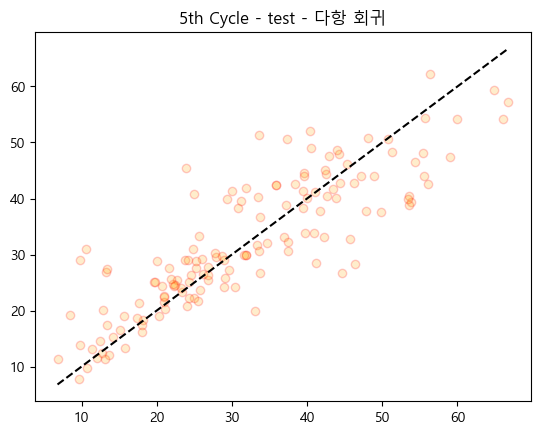

In [65]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('5th Cycle - test - 다항 회귀')
plt.show()

#### 5th Cycle - 다항 회귀 모델 학습 결과
- 이전 사이클에 비해 R2가 눈에 띄게 감소함

### 각종 회귀 모델로 학습

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = fifth_c_df.iloc[:, :-1], fifth_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 회귀모델 선언
# 주의: poly랑 병행하지 말 것
dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=100)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor()
lgb_r = LGBMRegressor(n_estimators=100)

# 반복문으로 fit하기 위해 list 안에 담기
models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]

for model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(model.__class__.__name__)
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 24.7918, RMSE: 4.9791, MSLE: 0.0387, RMSLE: 0.1967, R2: 0.8718
RandomForestRegressor
MSE: 28.0523, RMSE: 5.2964, MSLE: 0.0341, RMSLE: 0.1847, R2: 0.8550
GradientBoostingRegressor
MSE: 32.7540, RMSE: 5.7231, MSLE: 0.0365, RMSLE: 0.1911, R2: 0.8307
XGBRegressor
MSE: 18.8234, RMSE: 4.3386, MSLE: 0.0260, RMSLE: 0.1613, R2: 0.9027
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 4
[LightGBM] [Info] Start training from score 32.236667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

#### 5th Cycle - 각종 회귀 모델 학습 결과
- 이전 사이클과 마찬가지로, XGB 회귀 모델의 R2가 가장 높게 측정됨
- 또한, 위의 모델 전부 R2가 0.85 이상의 우수한 수치를 보임
- VIF와 pairplot으로 다중공선성이 남아있는지 확인해보기

### VIF Score 출력

In [67]:
# feature 별 VIF Score 출력
get_vif(features)

,vif_score,feature
0,9.261013,Cement
1,2.435195,Superplasticizer
2,11.784120,Coarse Aggregate
3,2.256292,Age


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

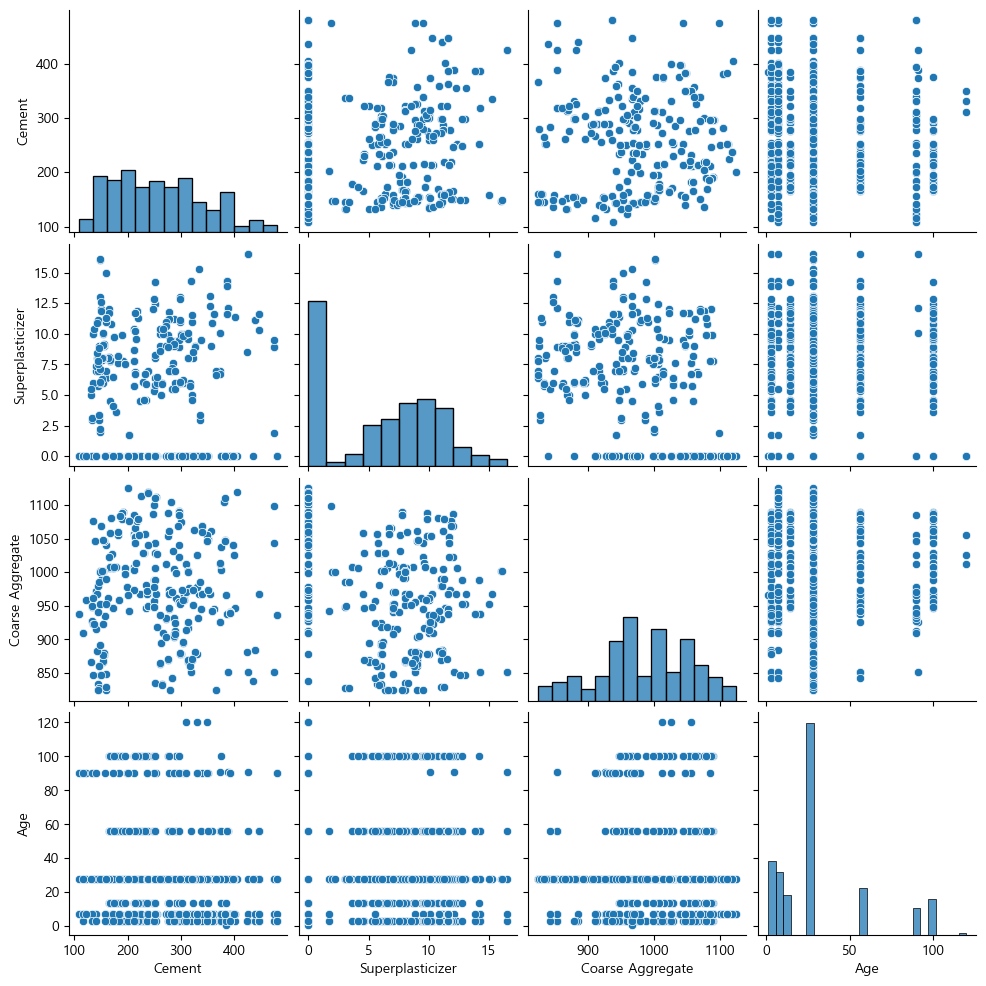

In [68]:
# 다중공선성 존재 여부를 확인하기 위해 pairplot 시각화
sns.pairplot(features)
plt.show()

#### 5th Cycle - VIF Score 출력 결과
- Coarse Aggrgate에서 높은 다중 공선성이 확인됨

### OLS 평가

In [69]:
from statsmodels.api import OLS

# 현재 데이터의 OLS 평가
model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Strength   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              2859.
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        23:37:14   Log-Likelihood:                         -2566.3
No. Observations:                 720   AIC:                                      5141.
Df Residuals:                     716   BIC:                                      5159.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

#### 5th Cycle - OLS 출력 결과
- 위의 VIF Score에서 이상이 발생했던 Coarse Aggregate가 타겟에 주는 영향이 적은 것으로 나타남
- 따라서 다음 사이클에서는 해당 feature를 삭제

### 6th Cycle - 데이터 전처리
- Coarse Aggregate 제거
- 만약 전반적으로 R2 Score가 떨어졌다면, Blast Furnace Slag를 제거하지 않고도 진행해볼 것

In [70]:
# 이전 사이클의 데이터 세트에서 일부 feature를 제거한 새로운 데이터 세트 생성
sixth_c_df = fifth_c_df.drop(labels=['Coarse Aggregate'], axis=1)
sixth_c_df

,Cement,Superplasticizer,Age,Strength
0,198.6,0.0,90,38.07
1,198.6,0.0,28,28.02
2,139.6,0.0,90,39.36
3,139.6,0.0,28,28.24
4,139.6,0.0,3,8.06
...,...,...,...,...
715,264.5,5.9,28,41.54
716,276.4,8.9,28,44.28
717,148.5,6.1,28,23.70
718,159.1,11.3,28,32.77


In [71]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
sixth_c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Age                 0.567925
Superplasticizer    0.441279
Cement              0.326046
Name: Strength, dtype: float64

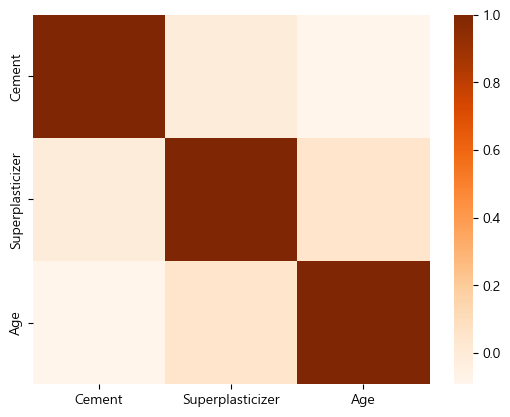

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(sixth_c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [73]:
# feature 간 상관관계를 데이터 세트 형태로 출력
sixth_c_df.iloc[:, :-1].corr()

,Cement,Superplasticizer,Age
Cement,1.000000,-0.009158,-0.092379
Superplasticizer,-0.009158,1.000000,0.049983
Age,-0.092379,0.049983,1.000000


### 선형 회귀 모델로 학습

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = sixth_c_df.iloc[:, :-1], sixth_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 73.7666, RMSE: 8.5887, MSLE: 0.0913, RMSLE: 0.3022, R2: 0.6410


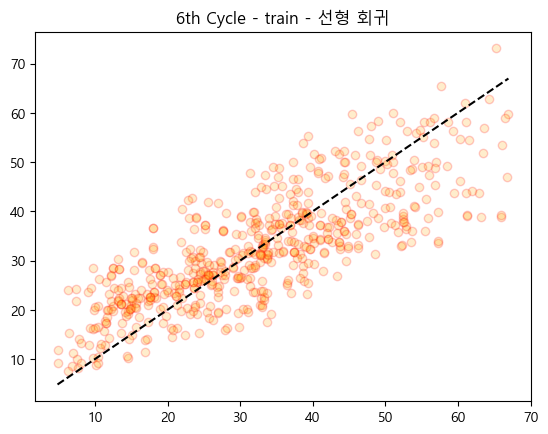

In [75]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('6th Cycle - train - 선형 회귀')
plt.show()

MSE: 71.2265, RMSE: 8.4396, MSLE: 0.0810, RMSLE: 0.2846, R2: 0.6317


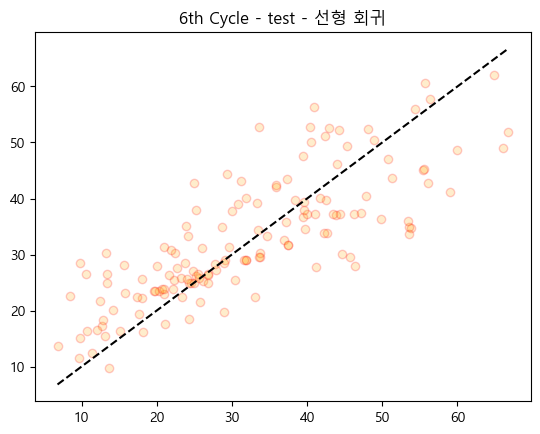

In [76]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('6th Cycle - test - 선형 회귀')
plt.show()

#### 6th Cycle - 선형 회귀 모델 학습 결과
- 이전 사이클에 비해 R2 Score가 약간 상승함
- 이는 다중 공선성이 발생한 Coarse Aggregate를 제거하면서 발생한 현상으로 추정

### Polynomial(다항 회귀) 학습

In [77]:
from sklearn.preprocessing import PolynomialFeatures

# 다항 회귀: degree는 차수를 의미함
poly_features = PolynomialFeatures(degree=2).fit_transform(features)
poly_features

array([[1.0000e+00, 1.9860e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        8.1000e+03],
       [1.0000e+00, 1.9860e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        7.8400e+02],
       [1.0000e+00, 1.3960e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        8.1000e+03],
       ...,
       [1.0000e+00, 1.4850e+02, 6.1000e+00, ..., 3.7210e+01, 1.7080e+02,
        7.8400e+02],
       [1.0000e+00, 1.5910e+02, 1.1300e+01, ..., 1.2769e+02, 3.1640e+02,
        7.8400e+02],
       [1.0000e+00, 2.6090e+02, 8.6000e+00, ..., 7.3960e+01, 2.4080e+02,
        7.8400e+02]])

In [78]:
X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 55.4516, RMSE: 7.4466, MSLE: 0.0648, RMSLE: 0.2545, R2: 0.7301


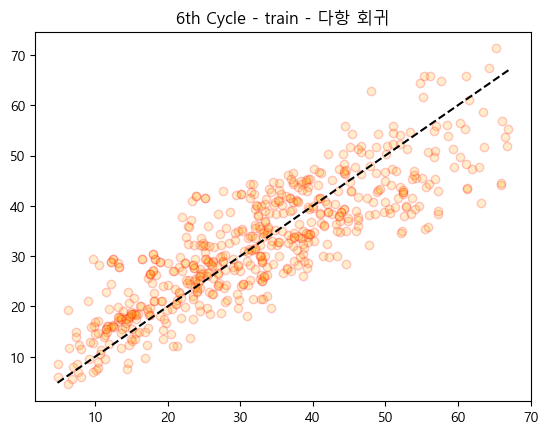

In [79]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('6th Cycle - train - 다항 회귀')
plt.show()

MSE: 47.5822, RMSE: 6.8980, MSLE: 0.0559, RMSLE: 0.2365, R2: 0.7540


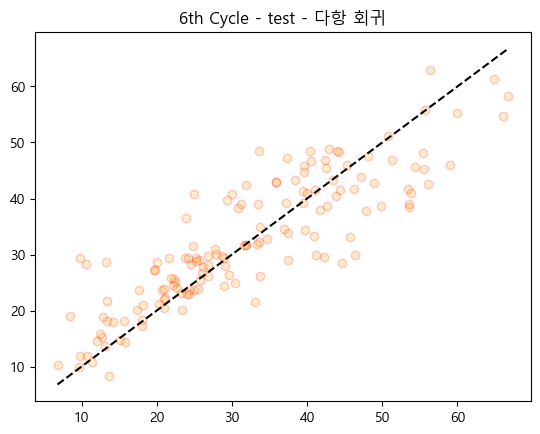

In [80]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('6th Cycle - test - 다항 회귀')
plt.show()

#### 6th Cycle - 다항 회귀 모델 학습 결과
- 이전 사이클에 비해 R2가 약간 증가했으며, 여전히 회귀선의 차수가 2일 때 가장 높은 R2를 기록함

### 각종 회귀 모델로 학습

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = sixth_c_df.iloc[:, :-1], sixth_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 회귀모델 선언
# 주의: poly랑 병행하지 말 것
dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=100)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor()
lgb_r = LGBMRegressor(n_estimators=100)

# 반복문으로 fit하기 위해 list 안에 담기
models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]

for model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(model.__class__.__name__)
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 56.3935, RMSE: 7.5096, MSLE: 0.0696, RMSLE: 0.2638, R2: 0.7084
RandomForestRegressor
MSE: 39.2231, RMSE: 6.2628, MSLE: 0.0466, RMSLE: 0.2159, R2: 0.7972
GradientBoostingRegressor
MSE: 33.8191, RMSE: 5.8154, MSLE: 0.0387, RMSLE: 0.1966, R2: 0.8252
XGBRegressor
MSE: 31.2125, RMSE: 5.5868, MSLE: 0.0395, RMSLE: 0.1988, R2: 0.8386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 3
[LightGBM] [Info] Start training from score 32.236667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

#### 6th Cycle - 각종 회귀 모델 학습 결과
- 이전 사이클과 마찬가지로, XGB 회귀 모델의 R2가 가장 높게 측정됨
- 전반적으로 R2가 이전 사이클에 비해 크게 감소함

### VIF Score 출력

In [82]:
# feature 별 VIF Score 출력
get_vif(features)

,vif_score,feature
0,2.740050,Cement
1,2.254662,Superplasticizer
2,1.958221,Age


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


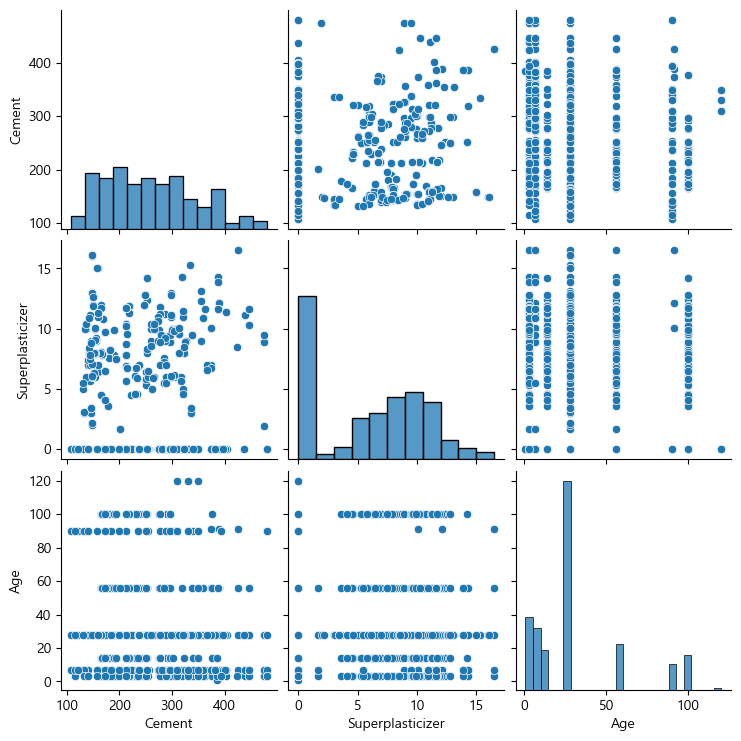

In [83]:
# 다중공선성 존재 여부를 확인하기 위해 pairplot 시각화
sns.pairplot(features)
plt.show()

#### 6th Cycle - VIF Score 출력 결과
- 기존에 존재했던 다중 공선성이 전부 해소됨

### OLS 평가

In [84]:
from statsmodels.api import OLS

# 현재 데이터의 OLS 평가
model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Strength   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3803.
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        23:37:16   Log-Likelihood:                         -2567.6
No. Observations:                 720   AIC:                                      5141.
Df Residuals:                     717   BIC:                                      5155.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

#### 6th Cycle - OLS 출력 결과
- 전반적으로 이전 사이클과 거의 동일한 양상을 보임

### 7th Cycle
- 만약 4 → 5 사이클로 넘어갈 때 Blast Furnace Slag를 제거하지 않았다면 R2가 지금보다 개선되었을까?
- 4번째 사이클에서 사용한 데이터 세트에서 Water와 Coarse Aggregate를 제거하고 이전 사이클과 결과 비교
> - 이전 사이클의 데이터에서 Blast Furnace Slag가 다시 추가되는 것

### 7th Cycle - 데이터 전처리

In [85]:
# 4번째 사이클에서의 데이터 세트에서 일부 feature 제거
seventh_c_df = fourth_c_df.drop(labels=['Water', 'Coarse Aggregate'], axis=1)
seventh_c_df

,Cement,Blast Furnace Slag,Superplasticizer,Age,Strength
0,198.6,132.4,0.0,90,38.07
1,198.6,132.4,0.0,28,28.02
2,139.6,209.4,0.0,90,39.36
3,139.6,209.4,0.0,28,28.24
4,139.6,209.4,0.0,3,8.06
...,...,...,...,...,...
715,264.5,111.0,5.9,28,41.54
716,276.4,116.0,8.9,28,44.28
717,148.5,139.4,6.1,28,23.70
718,159.1,186.7,11.3,28,32.77


In [86]:
# 원본 데이터 세트에서 feature와 타겟 데이터와의 상관관계 출력
seventh_c_df.corr()['Strength'].sort_values(ascending=False)[1:]

Age                   0.567925
Superplasticizer      0.441279
Cement                0.326046
Blast Furnace Slag    0.093006
Name: Strength, dtype: float64

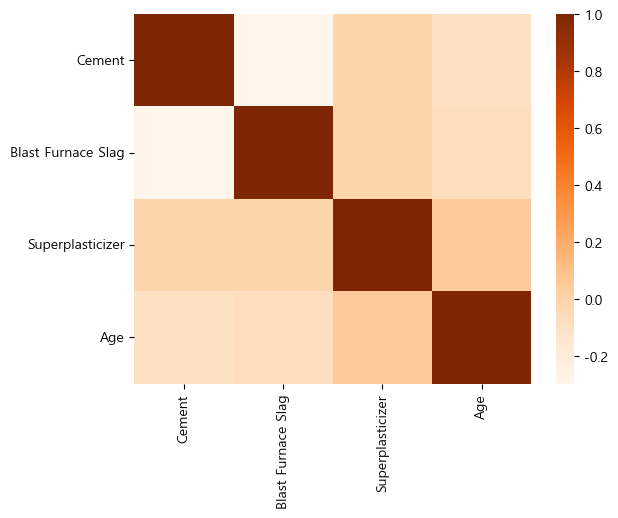

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature들 간 상관관계 출력
sns.heatmap(seventh_c_df.iloc[:, :-1].corr(), cmap='Oranges')
plt.show()

In [88]:
# feature 간 상관관계를 데이터 세트 형태로 출력
seventh_c_df.iloc[:, :-1].corr()

,Cement,Blast Furnace Slag,Superplasticizer,Age
Cement,1.000000,-0.296936,-0.009158,-0.092379
Blast Furnace Slag,-0.296936,1.000000,-0.006695,-0.077498
Superplasticizer,-0.009158,-0.006695,1.000000,0.049983
Age,-0.092379,-0.077498,0.049983,1.000000


#### 7th Cycle - 상관관계 시각화 결과
- Cement와 Blast Furnace Slag 사이에 상대적으로 높은 음의 상관관계가 발생
- 아래의 학습 결과로 Blast Furnace Slag 추가에 따른 변화가 어떤지 알아볼 것

### 선형 회귀 모델로 학습

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = seventh_c_df.iloc[:, :-1], seventh_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 59.0459, RMSE: 7.6841, MSLE: 0.0750, RMSLE: 0.2738, R2: 0.7126


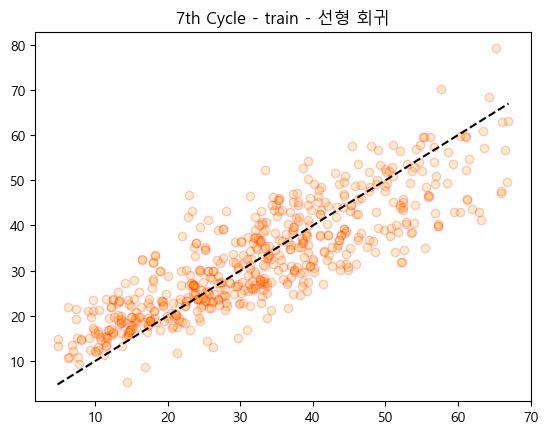

In [90]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('7th Cycle - train - 선형 회귀')
plt.show()

MSE: 56.8339, RMSE: 7.5388, MSLE: 0.0648, RMSLE: 0.2545, R2: 0.7062


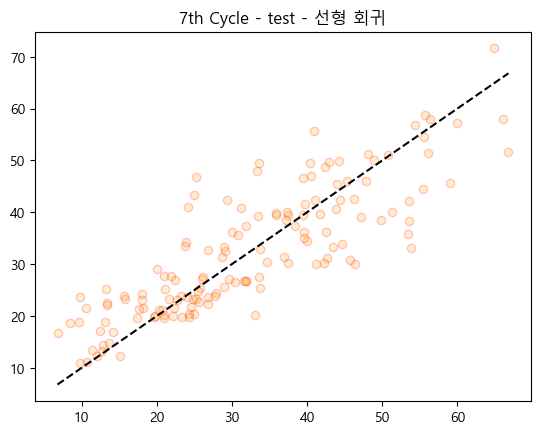

In [91]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('7th Cycle - test - 선형 회귀')
plt.show()

#### 7th Cycle - 선형 회귀 모델 학습 결과
- 이전 사이클에 비해 R2 Score가 상승함

### Polynomial(다항 회귀) 학습

In [92]:
from sklearn.preprocessing import PolynomialFeatures

# 다항 회귀: degree는 차수를 의미함
poly_features = PolynomialFeatures(degree=2).fit_transform(features)
poly_features

array([[1.0000e+00, 1.9860e+02, 1.3240e+02, ..., 0.0000e+00, 0.0000e+00,
        8.1000e+03],
       [1.0000e+00, 1.9860e+02, 1.3240e+02, ..., 0.0000e+00, 0.0000e+00,
        7.8400e+02],
       [1.0000e+00, 1.3960e+02, 2.0940e+02, ..., 0.0000e+00, 0.0000e+00,
        8.1000e+03],
       ...,
       [1.0000e+00, 1.4850e+02, 1.3940e+02, ..., 3.7210e+01, 1.7080e+02,
        7.8400e+02],
       [1.0000e+00, 1.5910e+02, 1.8670e+02, ..., 1.2769e+02, 3.1640e+02,
        7.8400e+02],
       [1.0000e+00, 2.6090e+02, 1.0050e+02, ..., 7.3960e+01, 2.4080e+02,
        7.8400e+02]])

In [93]:
X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

l_r = LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

MSE: 41.5276, RMSE: 6.4442, MSLE: 0.0640, RMSLE: 0.2529, R2: 0.7979


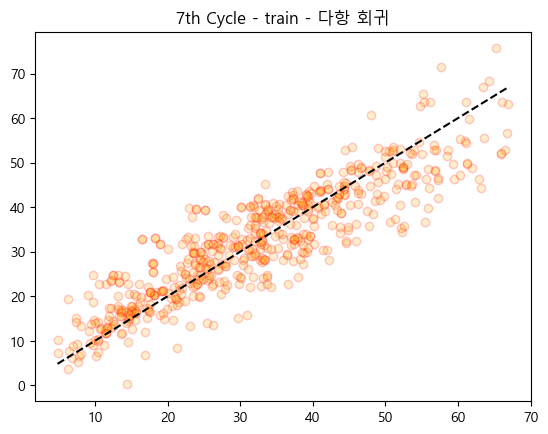

In [94]:
import matplotlib.pyplot as plt

# 폰트를 맑은 고딕으로 설정하고 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 훈련 후 train 데이터 예측하고 평가
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_train)
get_evaluation(y_train, prediction)

# train 데이터 분포 시각화
fig, ax = plt.subplots()

# 실제값과 예측값에 따른 분포를 산점도로 시각화
ax.scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)

# y = x 그래프를 점선으로 시각화
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.title('7th Cycle - train - 다항 회귀')
plt.show()

MSE: 35.5562, RMSE: 5.9629, MSLE: 0.0463, RMSLE: 0.2152, R2: 0.8162


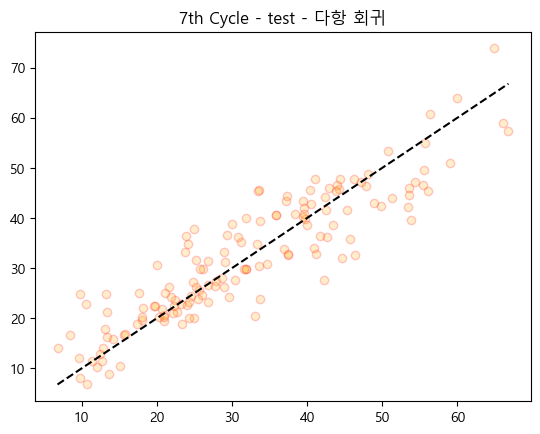

In [95]:
import matplotlib.pyplot as plt

# 같은 모델로 test 데이터 예측 결과 시각화
l_r.fit(X_train, y_train)
prediction = l_r.predict(X_test)
get_evaluation(y_test, prediction)

fig, ax = plt.subplots()
ax.scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('7th Cycle - test - 다항 회귀')
plt.show()

#### 7th Cycle - 다항 회귀 모델 학습 결과
- 이전 사이클에 비해 R2가 약간 증가함
- 여전히 회귀선의 차수가 2일 때 가장 높은 R2를 기록함

### 각종 회귀 모델로 학습

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 세트 분할 후 선형 회귀 모델로 훈련
features, targets = seventh_c_df.iloc[:, :-1], seventh_c_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 회귀모델 선언
# 주의: poly랑 병행하지 말 것
dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=100)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor()
lgb_r = LGBMRegressor(n_estimators=100)

# 반복문으로 fit하기 위해 list 안에 담기
models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]

for model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(model.__class__.__name__)
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 30.0916, RMSE: 5.4856, MSLE: 0.0422, RMSLE: 0.2055, R2: 0.8444
RandomForestRegressor
MSE: 23.0375, RMSE: 4.7997, MSLE: 0.0289, RMSLE: 0.1701, R2: 0.8809
GradientBoostingRegressor
MSE: 23.6710, RMSE: 4.8653, MSLE: 0.0285, RMSLE: 0.1689, R2: 0.8776
XGBRegressor
MSE: 17.3552, RMSE: 4.1660, MSLE: 0.0241, RMSLE: 0.1552, R2: 0.9103
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 4
[LightGBM] [Info] Start training from score 32.236667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

#### 7th Cycle - 각종 회귀 모델 학습 결과
- 전반적으로 R2가 이전 사이클에 비해 상승함
- 가장 높은 R2를 보이는 XGB 회귀 모델의 경우, 0.91이라는 매우 우수한 수치가 관측됨

### VIF Score 출력

In [97]:
# feature 별 VIF Score 출력
get_vif(features)

,vif_score,feature
0,2.876193,Cement
1,1.411223,Blast Furnace Slag
2,2.308734,Superplasticizer
3,1.969577,Age


#### 7th Cycle - VIF Score 출력 결과
- 이전 사이클과 마찬가지로, 다중 공선성이 발생한 feature가 존재하지 않음

### OLS 평가

In [98]:
from statsmodels.api import OLS

# 현재 데이터의 OLS 평가
model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:               Strength   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              3366.
Date:                Wed, 15 May 2024   Prob (F-statistic):                        0.00
Time:                        23:37:18   Log-Likelihood:                         -2510.8
No. Observations:                 720   AIC:                                      5030.
Df Residuals:                     716   BIC:                                      5048.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

#### 7th Cycle - OLS 출력 결과
- 이전 사이클에 비해 R2 Score가 약간 상승함

### 7th Cycle - 결론
- 현재의 데이터 세트가 다중 공선성이 발생하지 않은 데이터 세트 중 가장 높은 R2 Score를 기록함에 따라  
  가장 전처리가 잘 되어있으며, 필요한 feature들만 모여있는 데이터 세트라고 할 수 있음
- 6번째와 7번째 사이클을 비교했을 때, 타겟과의 상관관계가 낮다고 무작정 제거하는 것이 아니라,  
  해당 feature의 다중 공선성 발생 여부도 고려하여 제거할 feature를 선별하는 것이 좋다는 것을 알 수 있었음

### 최종 정리
- Cement, Blast Furnace SLag, Superplasticizer, Age의 4개 feature를 가진 데이터 세트를 사용했을 때  
  가장 신뢰할 수 있으면서도, 전반적으로 0.7 이상의 높은 R2 Score를 기록하는 모델들을 얻을 수 있었다.
- 그 중에서도 XGB 회귀 모델의 경우, R2 Score 0.91로 매우 우수한 결과를 보여주었다.
<br/><br/>
- 위 데이터 세트에 피쳐 엔지니어링을 적용, 새롭게 얻은 feature 하나로 단변량 회귀 테스트를 해보았지만,  
  R2 Score가 큰 폭으로 하락했다.
- 이에 따라 위 데이터 세트는 피쳐 엔지니어링을 하기에 적합하지 않다는 것을 알 수 있었다.